In [1]:
import torch
import pytorch_lightning as pl

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

from hydra.experimental import initialize, compose

import numpy as np
import time 
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(184)
np.random.seed(143)

print(torch.__version__)
print(device)

1.7.1
cuda:0


In [2]:
from bliss import sleep

In [3]:
import sys
sys.path.append('./starnet_utils/')
import m2_data
import plotting
import starnet_metrics
import daophot_utils
import utils

In [4]:
%matplotlib inline

# Load configs and starnet model

In [5]:
overrides = dict(
    model="sleep_m2",
    dataset="m2",
    training="m2",
    optimizer="m2"
)

overrides = [f"{key}={value}" for key, value in overrides.items()]

In [6]:
with initialize(config_path="../../config"):
    cfg = compose("config", overrides=overrides)

/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/initialize.py:35: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  warnings.warn(
/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/compose.py:16: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  warnings.warn(


In [7]:
model_filename = './fits/starnet-random_bg'

sleep_net = sleep.SleepPhase(**cfg.model.kwargs)
sleep_net.image_encoder.load_state_dict(torch.load(model_filename)); 

In [8]:
sleep_net.image_encoder.to(device);
sleep_net.image_encoder.eval(); 

In [9]:
border_padding = sleep_net.image_encoder.border_padding

# Load m2 data

In [10]:
run = 2583
camcol = 2
field = 136

sdss_frame, hubble_catalog, sdss_background, sdss_data, wcs = \
    m2_data.load_m2_data()

loading sdss image from ../../data/sdss/2583/2/136/frame-r-002583-2-0136.fits
loading sdss image from ../../data/sdss/2583/2/136/frame-i-002583-2-0136.fits
loading hubble data from  ./hubble_data/hlsp_acsggct_hst_acs-wfc_ngc7089_r.rdviq.cal.adj.zpt
getting sdss coordinates from:  ../../data/sdss/2583/2/136/frame-r-002583-2-0136.fits

 aligning images. 
 Getting sdss coordinates from:  ../../data/sdss/2583/2/136/frame-i-002583-2-0136.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [11]:
nelec_per_nmgy = sdss_data[0]['nelec_per_nmgy'][0].mean()

In [12]:
# filter by bright stars 
fmin = 1000.
hubble_catalog = plotting.filter_catalog(hubble_catalog,
                                         hubble_catalog['fluxes'][:, 0] > fmin)

### restrict to the subframe containing m2

In [45]:
x0 = 715
x1 = 30
m2_slen = 400

In [46]:
def plot_square_frame(ax): 
    ax.hlines(x0, xmin = x1, xmax = x1 + m2_slen, color = 'red')
    ax.hlines(x0 + m2_slen, xmin = x1, xmax = x1 + m2_slen, color = 'red')

    ax.vlines(x1, ymin = x0, ymax = x0 + m2_slen, color = 'red')
    ax.vlines(x1 + m2_slen, ymin = x0, ymax = x0 + m2_slen, color = 'red')


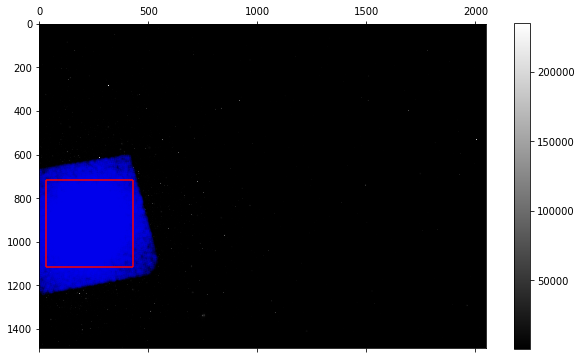

In [47]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))


plotting.plot_locations(
        hubble_catalog['locs'], 
        ax,
        marker='.',
        color='b', 
        alpha = 0.05
    )

im = plotting.plot_image(ax, 
                         sdss_frame[0])

plot_square_frame(ax)

f.colorbar(im, ax = ax)

In [63]:
def filter_by_radius(catalog, r): 
    center_coord = torch.Tensor([x0 + m2_slen / 2, x1 + m2_slen / 2])
    radius = torch.sqrt(((catalog['locs'] - center_coord)**2).sum(1))
    
    return(plotting.filter_catalog(catalog, radius > r))

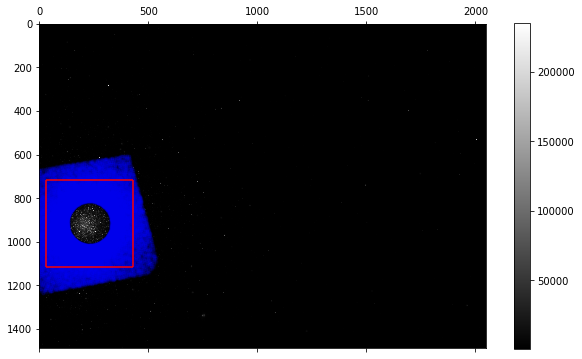

In [64]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))

out = filter_by_radius(hubble_catalog, 100)

plotting.plot_locations(
        out['locs'], 
        ax,
        marker='.',
        color='b', 
        alpha = 0.05
    )

im = plotting.plot_image(ax, 
                         sdss_frame[0])

plot_square_frame(ax)

f.colorbar(im, ax = ax)

In [65]:
sdss_test_image = plotting.crop_image(sdss_frame, 
                                      x0 - border_padding, 
                                      x1 - border_padding,
                                      m2_slen + 2 * border_padding,
                                      m2_slen + 2 * border_padding)

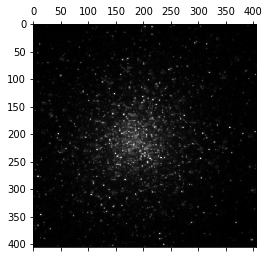

In [66]:
plt.matshow(sdss_test_image[0], 
            cmap = plt.cm.gray)

# Get starnet map estimates

In [67]:
map_estimate = sleep_net.image_encoder.map_estimate(sdss_test_image.unsqueeze(0).to(device), 
                                                    m2_slen)


# detach 
for key in map_estimate.keys(): 
    map_estimate[key] = map_estimate[key].squeeze(0).cpu().detach()

# reparameterize locations: these are coordinates on the frame
map_estimate['locs'] = map_estimate['locs'] * m2_slen + \
    torch.Tensor([[x0, x1]])

# all galaxies should be off
assert torch.all(map_estimate['galaxy_bool'] == 0.)

### Check the coverage

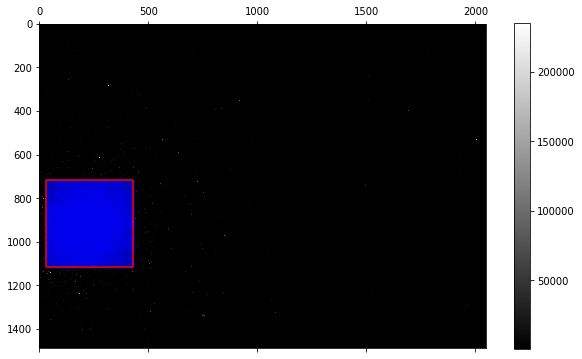

In [68]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))


plotting.plot_locations(
        map_estimate['locs'], 
        ax,
        marker='.',
        color='b', 
        alpha = 0.05
    )

im = plotting.plot_image(ax, 
                         sdss_frame[0])

plot_square_frame(ax)

f.colorbar(im, ax = ax)

In [69]:
map_estimate['locs'].shape

torch.Size([31748, 2])

# Load DAOPHOT results

In [70]:
import daophot_utils

In [71]:
_daophot_locs, _daophot_fluxes = daophot_utils.load_daophot_results('./daophot_data/m2_2583.phot', 
                                                                    nelec_per_nmgy, 
                                                                    wcs, 
                                                                    slen = m2_slen,
                                                                    x0 = x0,
                                                                    x1 = x1)

In [72]:
daophot_locs, daophot_fluxes = \
    daophot_utils.align_daophot_locs(_daophot_locs,
                                     _daophot_fluxes,
                                     hubble_catalog['locs'],
                                     hubble_catalog['fluxes'][:, 0], 
                                     align_on_logflux = 4.5)

daophot_catalog = {'locs': daophot_locs, 
                   'fluxes': daophot_fluxes}

# Example subimages

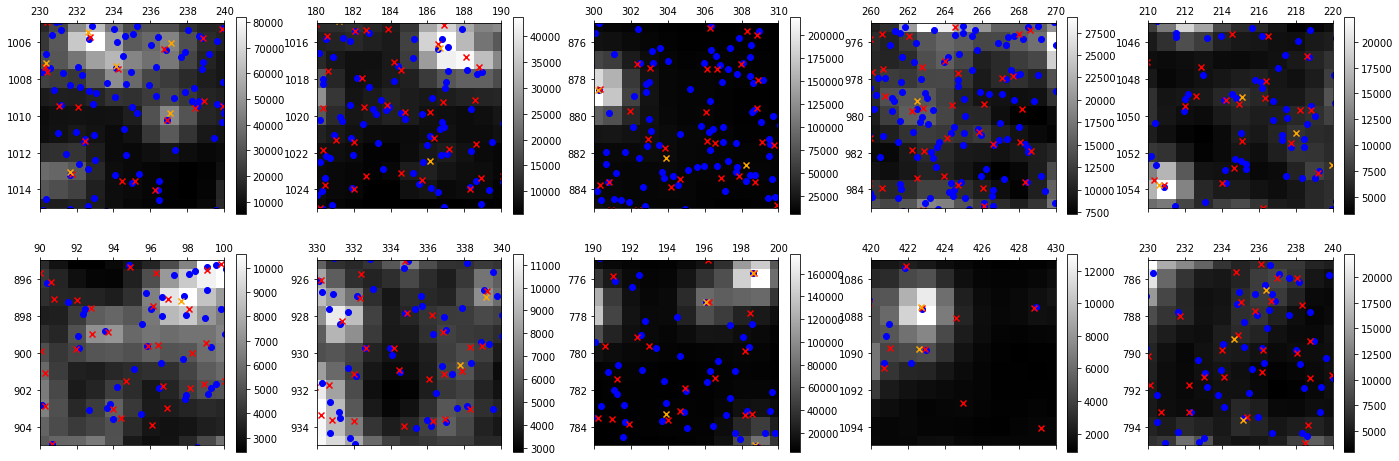

In [73]:
f, axarr = plt.subplots(2, 5, figsize=(24, 8))

subimage_slen = 10
x0_vec = np.arange(x0, x0 + m2_slen, subimage_slen)
x1_vec = np.arange(x1, x1 + m2_slen, subimage_slen)

for i in range(10): 
    _x0 = np.random.choice(x0_vec)
    _x1 = np.random.choice(x1_vec)
    
    ax = axarr[i // 5,  i % 5]
    
    plotting.plot_locations(
        hubble_catalog['locs'], 
        ax,
        marker='o',
        color='b',
    )
    
    plotting.plot_locations(
        map_estimate['locs'], 
        ax,
        marker='x',
        color='r',
    )
    
    plotting.plot_locations(
        daophot_locs, 
        ax,
        marker='x',
        color='orange',
    )
        
    im = plotting.plot_image(ax, 
                             sdss_frame[0], 
                             _x0, 
                             _x1,
                             subimage_slen,
                             subimage_slen)
    
    f.colorbar(im, ax = ax)

# Performance metrics

In [74]:
nelec_per_nmgy = sdss_data[0]['nelec_per_nmgy'][0].mean()

In [79]:
outer_radius = 100

In [80]:
# get hubble ground truth on this chunk
hubble_test_catalog = plotting.filter_catalog_by_locs(hubble_catalog, 
                                                      x0 , 
                                                      x1,
                                                      m2_slen,
                                                      m2_slen)

hubble_test_catalog = filter_by_radius(hubble_test_catalog, outer_radius)


hubble_test_mags = utils.convert_nmgy_to_mag(hubble_test_catalog['fluxes'][:, 0:1] / nelec_per_nmgy)

In [81]:
def get_summary_statistics(est_catalog): 
    
    est_catalog = filter_by_radius(est_catalog, outer_radius)
        
    est_locs = est_catalog['locs']
    est_fluxes = est_catalog['fluxes'][:, 0:1]
    
    est_mags = utils.convert_nmgy_to_mag(est_fluxes / nelec_per_nmgy)

    # get tpr and ppv as function of magnitude
    tpr_vec = starnet_metrics.get_tpr_vec(hubble_test_catalog['locs'],
                                          hubble_test_mags,
                                          est_locs,
                                          est_mags, 
                                          mag_bins = mag_bins)[0]
    
    ppv_vec = starnet_metrics.get_ppv_vec(hubble_test_catalog['locs'],
                                          hubble_test_mags,
                                          est_locs,
                                          est_mags, 
                                          mag_bins = mag_bins)[0]
    
    # get overal tpr and ppv    
    tpr, ppv = starnet_metrics.get_tpr_ppv(hubble_test_catalog['locs'],
                                           hubble_test_mags,
                                           est_locs,
                                           est_mags, 
                                           slack = 0.5)
    # f1 score 
    f1 = 2 * (tpr * ppv) / (tpr + ppv)
    return tpr, ppv, f1, tpr_vec, ppv_vec


In [82]:
mag_bins = np.concatenate((np.array([15]), 
                          np.arange(19, 22.2, 0.4), 
                          np.array([100])))

### Get results for StarNet

In [83]:
tpr, ppv, f1, starnet_tpr_vec, starnet_ppv_vec = \
    get_summary_statistics(map_estimate)

print('StarNet tpr', tpr)
print('StarNet ppv', ppv)
print('StarNet f1', f1)

StarNet tpr tensor(0.2553)
StarNet ppv tensor(0.4729)
StarNet f1 tensor(0.3316)


In [84]:
tpr, ppv, f1, daophot_tpr_vec, daophot_ppv_vec = \
    get_summary_statistics(daophot_catalog)

print('DAOPHOT tpr', tpr)
print('DAOPHOT ppv', ppv)
print('DAOPHOT f1', f1)

DAOPHOT tpr tensor(0.0426)
DAOPHOT ppv tensor(0.4492)
DAOPHOT f1 tensor(0.0778)


# Get performance metrics statistics as a function of magnitude

In [85]:
axis_label_size = 20
ticksize = 12
legendsize = 12
markersize = 10
linewidth = 2
titlesize = 18

In [86]:
def plot_summary_vec(summary_vec, ax, marker, color, label): 
    ax.plot(x_tmp[:-1],
            summary_vec,
            marker, 
            markersize = markersize, 
            linewidth = linewidth, 
            color = color, 
            label = label)


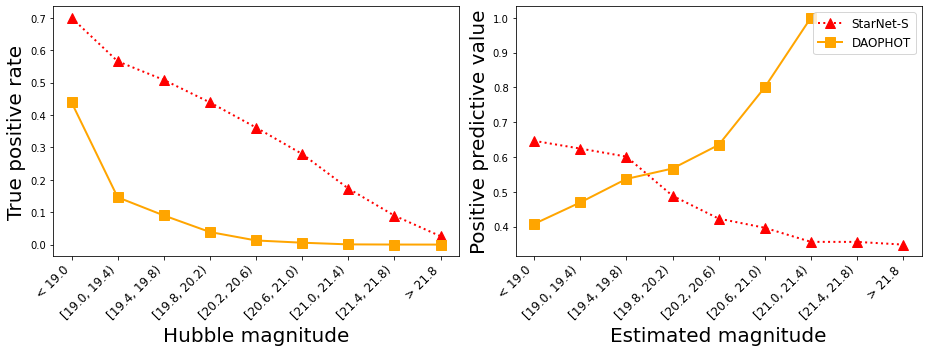

In [87]:
fig, axarr = plt.subplots(1, 2, figsize=(13, 5))

x_tmp = np.arange(len(mag_bins))

############### 
# true positive rates
###############
plot_summary_vec(starnet_tpr_vec, 
                 axarr[0], 
                 marker = ':^', 
                 color = 'r', 
                 label = 'StarNet-S')

plot_summary_vec(daophot_tpr_vec, 
                 axarr[0], 
                 marker = '-s', 
                 color = 'orange', 
                 label = 'DAOPHOT')

################
# positive predictive values
###############
plot_summary_vec(starnet_ppv_vec, 
                 axarr[1], 
                 marker = ':^', 
                 color = 'r', 
                 label = 'StarNet-S')

# no detection at lower magnitudes. 
# don't plot them
daophot_ppv_vec[daophot_ppv_vec == 0] = np.inf
plot_summary_vec(daophot_ppv_vec, 
                 axarr[1], 
                 marker = '-s', 
                 color = 'orange', 
                 label = 'DAOPHOT')

###############
# Legend
###############
axarr[1].legend(prop={'size': legendsize})

###############
# axis labels
###############
axarr[0].set_xlabel('Hubble magnitude', fontsize = axis_label_size)
axarr[1].set_xlabel('Estimated magnitude', fontsize = axis_label_size)
axarr[0].set_ylabel('True positive rate', fontsize = axis_label_size)
axarr[1].set_ylabel('Positive predictive value', fontsize = axis_label_size)


labels_raw = np.round(mag_bins, 1)
labels = ['[' + str(labels_raw[i]) + ', ' + str(labels_raw[i+1]) + ')' for i in range(len(labels_raw) - 1)]

labels[0] = '< ' + str(labels_raw[1])
labels[-1] = '> ' + str(labels_raw[-2])

for i in range(2): 
    axarr[i].set_xticks(x_tmp[:-1])
    axarr[i].set_xticklabels(labels, rotation=45, ha = 'right', 
                             fontsize = axis_label_size * 0.6)

fig.tight_layout()


/tmp/ipykernel_4097675/3019315365.py:14: RuntimeWarning: invalid value encountered in multiply
  plot_summary_vec(2 * daophot_tpr_vec * daophot_ppv_vec / (daophot_tpr_vec + daophot_ppv_vec),
/tmp/ipykernel_4097675/3019315365.py:14: RuntimeWarning: invalid value encountered in true_divide
  plot_summary_vec(2 * daophot_tpr_vec * daophot_ppv_vec / (daophot_tpr_vec + daophot_ppv_vec),
No handles with labels found to put in legend.


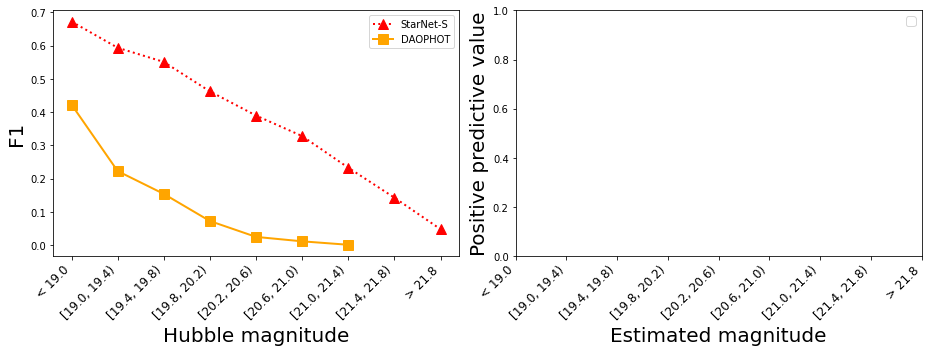

In [88]:
fig, axarr = plt.subplots(1, 2, figsize=(13, 5))

x_tmp = np.arange(len(mag_bins))

############### 
# true positive rates
###############
plot_summary_vec(2 * starnet_tpr_vec * starnet_ppv_vec / (starnet_ppv_vec + starnet_tpr_vec), 
                 axarr[0], 
                 marker = ':^', 
                 color = 'r', 
                 label = 'StarNet-S')

plot_summary_vec(2 * daophot_tpr_vec * daophot_ppv_vec / (daophot_tpr_vec + daophot_ppv_vec), 
                 axarr[0], 
                 marker = '-s', 
                 color = 'orange', 
                 label = 'DAOPHOT')

################
# positive predictive values
###############
# plot_summary_vec(starnet_ppv_vec, 
#                  axarr[1], 
#                  marker = ':^', 
#                  color = 'r', 
#                  label = 'StarNet-S')

# # no detection at lower magnitudes. 
# # don't plot them
# daophot_ppv_vec[daophot_ppv_vec == 0] = np.inf
# plot_summary_vec(daophot_ppv_vec, 
#                  axarr[1], 
#                  marker = '-s', 
#                  color = 'orange', 
#                  label = 'DAOPHOT')

###############
# Legend
###############
axarr[1].legend(prop={'size': legendsize})

###############
# axis labels
###############
axarr[0].set_xlabel('Hubble magnitude', fontsize = axis_label_size)
axarr[1].set_xlabel('Estimated magnitude', fontsize = axis_label_size)
axarr[0].set_ylabel('F1', fontsize = axis_label_size)
axarr[1].set_ylabel('Positive predictive value', fontsize = axis_label_size)

labels_raw = np.round(mag_bins, 1)
labels = ['[' + str(labels_raw[i]) + ', ' + str(labels_raw[i+1]) + ')' for i in range(len(labels_raw) - 1)]

labels[0] = '< ' + str(labels_raw[1])
labels[-1] = '> ' + str(labels_raw[-2])

for i in range(2): 
    axarr[i].set_xticks(x_tmp[:-1])
    axarr[i].set_xticklabels(labels, rotation=45, ha = 'right', 
                             fontsize = axis_label_size * 0.6)

fig.tight_layout()

axarr[0].legend();

In [89]:
def get_mags_and_colors(catalog): 
    
    fluxes = catalog['fluxes']
    
    mag1 = utils.convert_nmgy_to_mag(fluxes[:, 0] / nelec_per_nmgy)
    mag2 = utils.convert_nmgy_to_mag(fluxes[:, 1] / nelec_per_nmgy)
    
    color = mag2 - mag1
    
    return mag1, color

In [90]:
starnet_mags, starnet_colors = get_mags_and_colors(map_estimate)

In [91]:
daophot_file = np.loadtxt('./daophot_data/m2_2583.phot')

# load desired quantities
daophot_rmags = daophot_file[:, 22]
daophot_imags = daophot_file[:, 29]

which_keep = (daophot_rmags < 99) & (daophot_imags < 99)
daophot_rmags = daophot_rmags[which_keep]
daophot_imags = daophot_imags[which_keep]

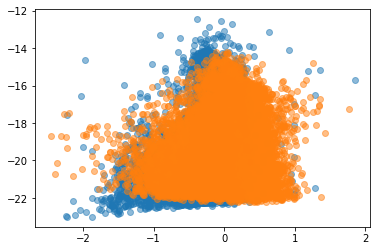

In [92]:
plt.scatter(daophot_imags - daophot_rmags, 
            -daophot_rmags, alpha = 0.5)

plt.scatter(starnet_colors, 
            -starnet_mags, alpha = 0.5)

In [149]:
hubble_cat_file = './hubble_data/hlsp_acsggct_hst_acs-wfc_ngc7089_r.rdviq.cal.adj.zpt'
print('loading hubble data from ', hubble_cat_file)
HTcat = np.loadtxt(hubble_cat_file, skiprows=True)

# hubble magnitude
hubble_rmag = HTcat[:,9]
hubble_imag = HTcat[:,10]

loading hubble data from  ./hubble_data/hlsp_acsggct_hst_acs-wfc_ngc7089_r.rdviq.cal.adj.zpt


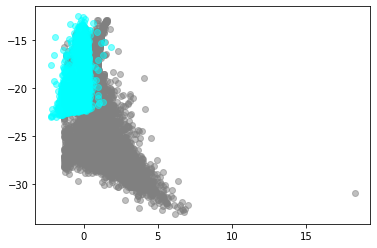

In [150]:
plt.scatter(hubble_rmag - hubble_imag, 
            -hubble_rmag, alpha = 0.5, color = 'grey')

plt.scatter(daophot_imags - daophot_rmags, 
            -daophot_rmags, alpha = 0.5, color = 'cyan')

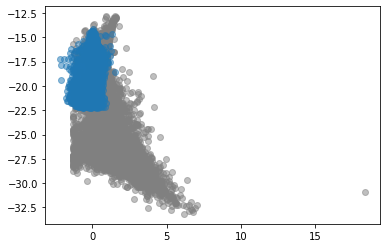

In [151]:
plt.scatter(hubble_rmag - hubble_imag, 
            -hubble_rmag, alpha = 0.5, color = 'grey')


plt.scatter(starnet_colors, 
            -starnet_mags, alpha = 0.5)

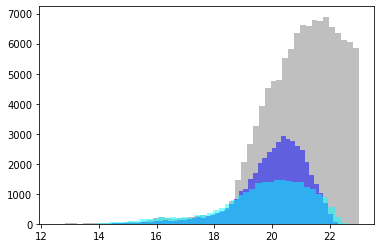

In [163]:
plt.hist(hubble_rmag[hubble_rmag < 23], 
         alpha = 0.5, color = 'grey', 
         bins = 50);


plt.hist(starnet_mags, 
         alpha = 0.5, color = 'blue', 
         bins = 50);

plt.hist(daophot_rmags, 
         alpha = 0.5, color = 'cyan', 
         bins = 50);

In [170]:
def get_matched_bool(est_locs, true_locs, est_mag, true_mag): 
    slack = 0.5 
    
    locs_error = torch.abs(est_locs.unsqueeze(0) - true_locs.unsqueeze(1)).max(-1)[0]

    # worst error in either band
    mag_error = torch.abs(est_mag.unsqueeze(0) - true_mag.unsqueeze(1)).max(-1)[0]

    ppv_bool = torch.any((locs_error < slack) * (mag_error < slack), dim=0).float()
    
    return ppv_bool

In [174]:
starnet_mags = utils.convert_nmgy_to_mag(map_estimate['fluxes'][:, 0:1] / nelec_per_nmgy)


which_keep_starnet = get_matched_bool(map_estimate['locs'], 
                              hubble_test_catalog['locs'], 
                              starnet_mags, 
                              hubble_test_mags)

In [183]:
daophot_catalog['fluxes']

tensor([[ 18989.9453],
        [ 19738.9355],
        [ 11233.7227],
        ...,
        [289816.9062],
        [ 19342.9941],
        [ 12933.7275]])

In [184]:
daophot_mags = utils.convert_nmgy_to_mag(daophot_catalog['fluxes'][:, 0:1] / nelec_per_nmgy)


which_keep_daophot = get_matched_bool(daophot_catalog['locs'], 
                                      hubble_test_catalog['locs'], 
                                      daophot_mags, 
                                      hubble_test_mags)

(0.0, 2000.0)

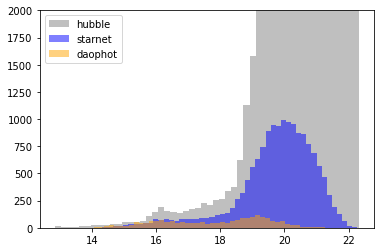

In [192]:
plt.hist(hubble_test_mags.squeeze().numpy(), 
         alpha = 0.5, color = 'grey', 
         bins = 50, 
         label = 'hubble');


plt.hist(starnet_mags.squeeze().numpy()[which_keep_starnet == 1], 
         alpha = 0.5, color = 'blue', 
         bins = 50, 
        label = 'starnet');

plt.hist(daophot_mags.squeeze().numpy()[which_keep_daophot == 1], 
         alpha = 0.5, color = 'orange', 
         bins = 50,  
         label = 'daophot');

plt.legend()
plt.ylim(0, 2000)